# Mask R-CNN - Soma Pipeline

Based on Nucleus sample from https://github.com/matterport/Mask_RCNN \
See poster for more information or conctact me.

In [2]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

# We are using modified Mask RCNN configuration initially designed for nuclei segmentation
import nucleus

%matplotlib inline

## Configurations

In [3]:
# Dataset directory
DATASET_DIR = os.path.join(ROOT_DIR, "datasets/soma/pipeline")
LOGS_DIR = os.path.join(ROOT_DIR, "logs")

# Inference Configuration
config = nucleus.NucleusInferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                2.0
IMAGE_RESIZE_MODE              pad64
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [4]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# Only inference mode is supported right now
TEST_MODE = "inference"

In [5]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    fig.tight_layout()
    return ax

In [6]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference",
                              model_dir=LOGS_DIR,
                              config=config)

Instructions for updating:
Use fn_output_signature instead


In [7]:
# Path to a specific weights file
weights_path = "/logs/nucleus20200530T2120/mask_rcnn_nucleus_0040.h5"


# Load weights
print("Loading weights ..." + weights_path)
model.load_weights(ROOT_DIR + weights_path, by_name=True)

Loading weights .../logs/nucleus20200530T2120/mask_rcnn_nucleus_0040.h5
Re-starting from epoch 40


## Experimental parameters

In [8]:
# Experimental settings as written in the file name.
settings_tags = ["ctrl", "bic", "ttx"]
# Description of experimental settings as to be previewed on the graph.
settings_graph = ["Control", "BiC", "TTX"]
# Amount of images for each setting
image_count_per_setting = [3, 3, 3]

if len(settings_tags) == len(settings_graph) == len(image_count_per_setting):
    print("Good to go!")
else:
    print("Lists have different lengths! Make sure you add information about each experimental setting.")

Good to go!


In [9]:
# Map each repository name to the corresponding ID (for example, "ctrl3map -> 23")
repo_name_to_id = dict()
repo_name_to_results = dict()
repo_name_to_soma_avg_intensities = dict()
setting_to_soma_intensities = dict()
dataset = utils.Dataset()
dataset.add_class("Soma", 1, "Soma")
from PIL import Image, ImageDraw

n_id = 0
for n_setting in range(len(settings_tags)):
    for n_image in range(1, image_count_per_setting[n_setting] + 1):
        
        map2_image_name = str(settings_tags[n_setting] + str(n_image) + "map")
        signal_image_name = str(settings_tags[n_setting] + str(n_image) + "signal")
        
        # Add MAP2 image to dataset and match it with the ID
        dataset.add_image("Soma", map2_image_name, os.path.join(DATASET_DIR, 
                                                                map2_image_name +"/images/"+ map2_image_name +".png"))
        repo_name_to_id[map2_image_name] = n_id
        n_id += 1
        
        # Add signal image to dataset and match it with the ID
        dataset.add_image("Soma", signal_image_name, os.path.join(DATASET_DIR, 
                                                                signal_image_name +"/images/"+ signal_image_name +".png"))
        repo_name_to_id[signal_image_name] = n_id
        n_id += 1
    setting_to_soma_intensities[settings_tags[n_setting]] = []
        
dataset.prepare()

In [12]:
for n_setting in range(len(settings_tags)):
    for n_image in range(1, image_count_per_setting[n_setting] + 1):
        map2_image_name = str(settings_tags[n_setting] + str(n_image) + "map")
        signal_image_name = str(settings_tags[n_setting] + str(n_image) + "signal")
        
        # Get image and meta data
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config, repo_name_to_id[map2_image_name], use_mini_mask=False);
        
        # Run object detection
        results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1);
        
        # Save results to dictionary
        r = results[0]
        repo_name_to_results[map2_image_name] = r
        
        print(repo_name_to_id[signal_image_name])
        signal_image = dataset.load_image(repo_name_to_id[signal_image_name]);
        signal_image, window, scale, padding, crop = utils.resize_image(signal_image, 512, 512, 2.0, "pad64")
        
        # Convert image to grayscale
        rgb_weights = [0.2989, 0.5870, 0.1140]
        grayscale_image = np.dot(signal_image[...,:3], rgb_weights)

        soma_avg_intensities = []

        for i in range(len(r['masks'][0,0,:])):
            soma = 0
            area = 0
            for row in range(len(grayscale_image)):
                for value in range(len(grayscale_image[row])):
                    if r['masks'][row, value, i]:
                        area += 1
                        soma += grayscale_image[row, value]
            soma_avg_intensities.append(soma/area)
        
        repo_name_to_soma_avg_intensities[map2_image_name] = soma_avg_intensities
        setting_to_soma_intensities[settings_tags[n_setting]] =\
            setting_to_soma_intensities[settings_tags[n_setting]] + soma_avg_intensities

[0]
(520, 696, 3)
(1088, 1408, 3)
(24, 8, 1064, 1400)
2.0
[1 1]
Processing 1 images
image                    shape: (1088, 1408, 3)       min:    0.00000  max:  253.00000  uint8
molded_images            shape: (1, 1088, 1408, 3)    min:    0.00000  max:  253.00000  uint8
image_metas              shape: (1, 14)               min:    0.00000  max: 1408.00000  float64
anchors                  shape: (1, 382602, 4)        min:   -0.08327  max:    1.02439  float32
1


[2]
(520, 696, 3)
(1088, 1408, 3)
(24, 8, 1064, 1400)
2.0
[1 1]
Processing 1 images
image                    shape: (1088, 1408, 3)       min:    0.00000  max:  229.00000  uint8
molded_images            shape: (1, 1088, 1408, 3)    min:    0.00000  max:  229.00000  uint8
image_metas              shape: (1, 14)               min:    1.00000  max: 1408.00000  float64
anchors                  shape: (1, 382602, 4)        min:   -0.08327  max:    1.02439  float32
3


[4]
(520, 696, 3)
(1088, 1408, 3)
(24, 8, 1064, 1400)
2.0
[1 1]
Processing 1 images
image                    shape: (1088, 1408, 3)       min:    0.00000  max:  252.00000  uint8
molded_images            shape: (1, 1088, 1408, 3)    min:    0.00000  max:  252.00000  uint8
image_metas              shape: (1, 14)               min:    1.00000  max: 1408.00000  float64
anchors                  shape: (1, 382602, 4)        min:   -0.08327  max:    1.02439  float32
5


[6]
(520, 696, 3)
(1088, 1408, 3)
(24, 8, 1064, 1400)
2.0
[1 1]
Processing 1 images
image                    shape: (1088, 1408, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1088, 1408, 3)    min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 14)               min:    1.00000  max: 1408.00000  float64
anchors                  shape: (1, 382602, 4)        min:   -0.08327  max:    1.02439  float32
7


[8]
(520, 696, 3)
(1088, 1408, 3)
(24, 8, 1064, 1400)
2.0
[1 1]
Processing 1 images
image                    shape: (1088, 1408, 3)       min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 1088, 1408, 3)    min:    0.00000  max:  254.00000  uint8
image_metas              shape: (1, 14)               min:    1.00000  max: 1408.00000  float64
anchors                  shape: (1, 382602, 4)        min:   -0.08327  max:    1.02439  float32
9


[10]
(520, 696, 3)
(1088, 1408, 3)
(24, 8, 1064, 1400)
2.0
[1 1]
Processing 1 images
image                    shape: (1088, 1408, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1088, 1408, 3)    min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 14)               min:    1.00000  max: 1408.00000  float64
anchors                  shape: (1, 382602, 4)        min:   -0.08327  max:    1.02439  float32
11


[12]
(520, 696, 3)
(1088, 1408, 3)
(24, 8, 1064, 1400)
2.0
[1 1]
Processing 1 images
image                    shape: (1088, 1408, 3)       min:    0.00000  max:  251.00000  uint8
molded_images            shape: (1, 1088, 1408, 3)    min:    0.00000  max:  251.00000  uint8
image_metas              shape: (1, 14)               min:    1.00000  max: 1408.00000  float64
anchors                  shape: (1, 382602, 4)        min:   -0.08327  max:    1.02439  float32
13


[14]
(520, 696, 3)
(1088, 1408, 3)
(24, 8, 1064, 1400)
2.0
[1 1]
Processing 1 images
image                    shape: (1088, 1408, 3)       min:    0.00000  max:  248.00000  uint8
molded_images            shape: (1, 1088, 1408, 3)    min:    0.00000  max:  248.00000  uint8
image_metas              shape: (1, 14)               min:    1.00000  max: 1408.00000  float64
anchors                  shape: (1, 382602, 4)        min:   -0.08327  max:    1.02439  float32
15


[16]
(520, 696, 3)
(1088, 1408, 3)
(24, 8, 1064, 1400)
2.0
[1 1]
Processing 1 images
image                    shape: (1088, 1408, 3)       min:    0.00000  max:  245.00000  uint8
molded_images            shape: (1, 1088, 1408, 3)    min:    0.00000  max:  245.00000  uint8
image_metas              shape: (1, 14)               min:    1.00000  max: 1408.00000  float64
anchors                  shape: (1, 382602, 4)        min:   -0.08327  max:    1.02439  float32
17


## Example

[0]
(520, 696, 3)
(1088, 1408, 3)
(24, 8, 1064, 1400)
2.0
[1 1]
Processing 1 images
image                    shape: (1088, 1408, 3)       min:    0.00000  max:  253.00000  uint8
molded_images            shape: (1, 1088, 1408, 3)    min:    0.00000  max:  253.00000  uint8
image_metas              shape: (1, 14)               min:    0.00000  max: 1408.00000  float64
anchors                  shape: (1, 382602, 4)        min:   -0.08327  max:    1.02439  float32


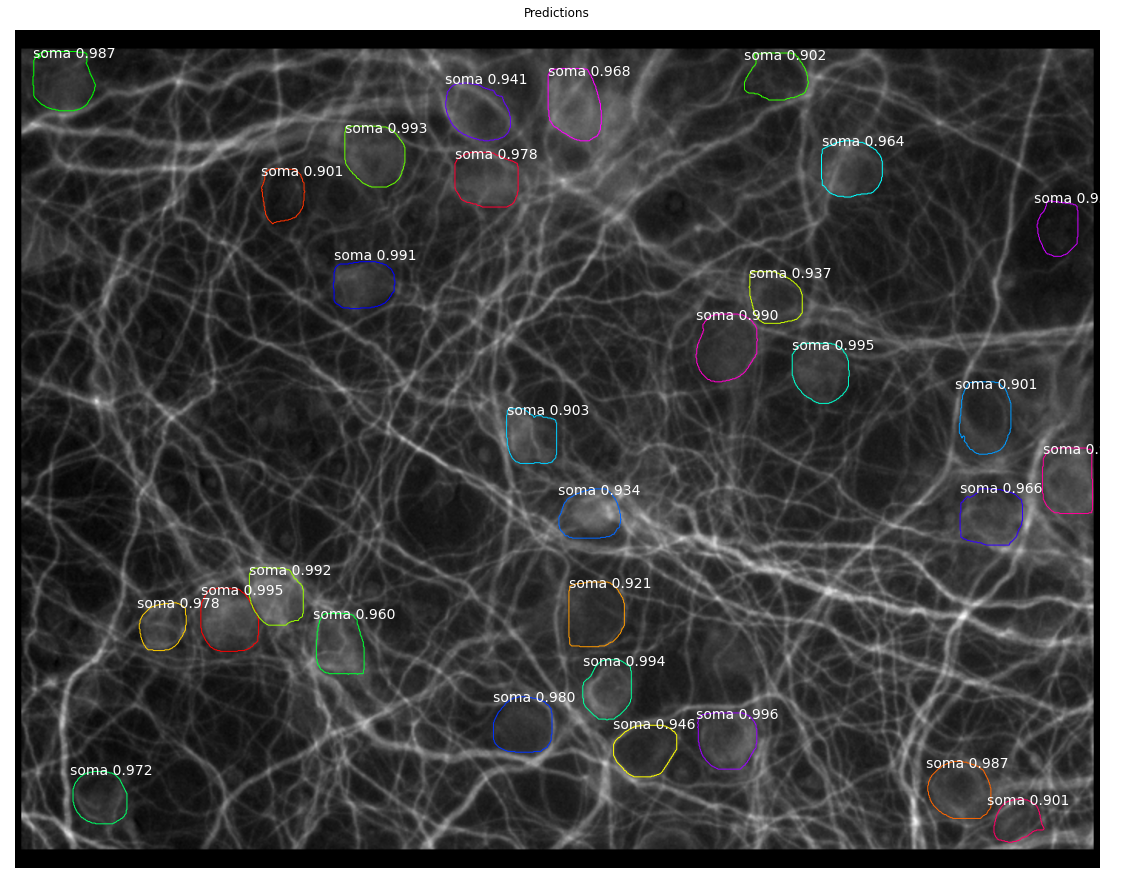

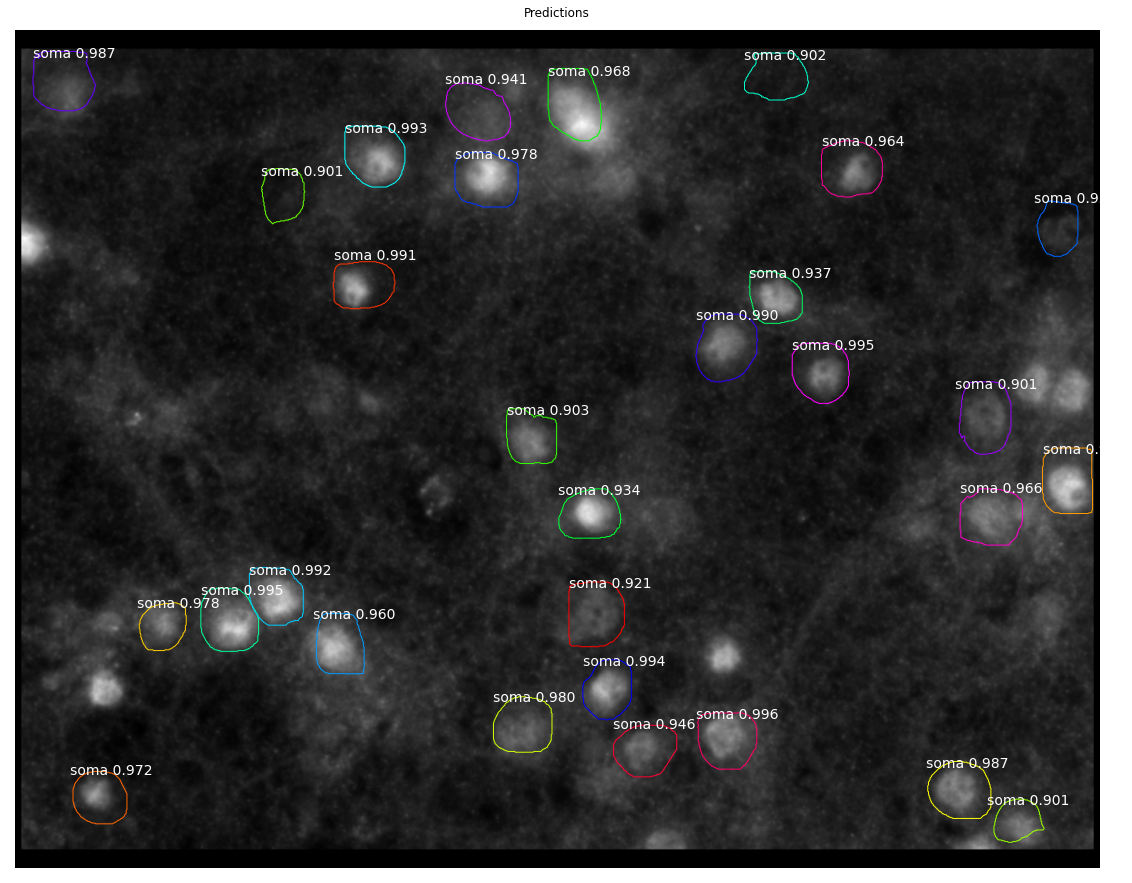

In [13]:
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config, 0, use_mini_mask=False);

 # Run object detection
results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)
        
# Save results to dictionary
r = results[0]

visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            ['BG', 'soma'], r['scores'], ax=get_ax(1),
                            show_bbox=False, show_mask=False,
                            title="Predictions")

signal_image = dataset.load_image(1)
signal_image, window, scale, padding, crop = utils.resize_image(signal_image, 512, 512, 2.0, "pad64")
visualize.display_instances(signal_image, r['rois'], r['masks'], r['class_ids'], 
                            ['BG', 'soma'], r['scores'], ax=get_ax(1),
                            show_bbox=False, show_mask=False,
                            title="Predictions")

## Data analysis

Control	| Mean intensity per pixel: 69.23 ± 21.94
BiC	| Mean intensity per pixel: 47.42 ± 19.63
TTX	| Mean intensity per pixel: 56.29 ± 23.04


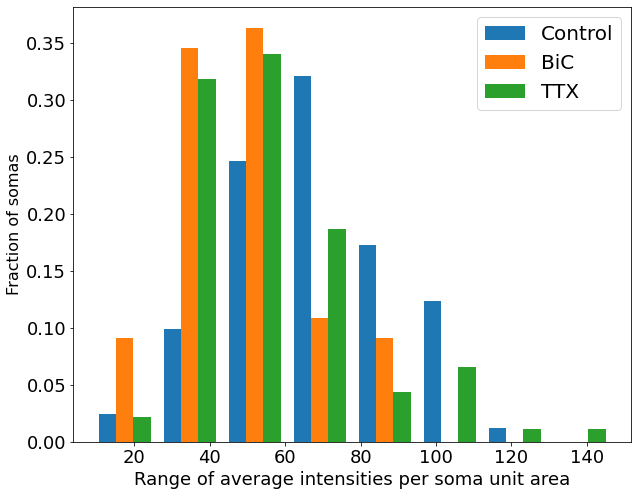

In [14]:
setting_weights = []
setting_values = []

for n_setting in range(len(settings_tags)):
    setting_weights.append(np.ones_like(
        setting_to_soma_intensities[settings_tags[n_setting]]) / 
                           len(setting_to_soma_intensities[settings_tags[n_setting]]))

    setting_values.append(setting_to_soma_intensities[settings_tags[n_setting]])
    print(settings_graph[n_setting]
          + "\t| Mean intensity per pixel: "
          + str(round(np.mean(np.asarray(setting_to_soma_intensities[settings_tags[n_setting]])), 2)) + " ± "
          + str(round(np.std(np.asarray(setting_to_soma_intensities[settings_tags[n_setting]])), 2)))
    
matplotlib.rcParams.update({'font.size': 18})
plt.figure(figsize=[10,8])
plt.xlabel('Range of average intensities per soma unit area', fontsize=18)
plt.ylabel('Fraction of somas', fontsize=16)

n, bins, patches = plt.hist(setting_values, 
                            weights=setting_weights,
                            label=settings_graph, 
                            bins=8)

plt.legend( prop={'size': 20})
plt.show()